нормализация, n-граммы + tf-idf. Возможно, PCA. Затем, линейные модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("train.csv", encoding="ISO-8859-1")
df.sample(5)

,Id,Hotel_name,Review_Title,Review_Text,Rating
694,694,Lake View Park,Response about 3 guests,Everything is good. But when we went for check...,86.0
611,611,Dee Cee Manor,Spacious rooms & centrally located,This good and old hotel once upon a time. Alth...,71.0
316,316,Grand Chennai by GRT Hotels,Excellent for Families!,Recently renovated and clean room. Spacious an...,100.0
1392,1392,Raj Palace Hotel,Had a comfortable stay,The location and service personnels were aweso...,71.0
365,365,MGM Eastwoods,Conversation was not that much,MGM Eastwoods,86.0


<AxesSubplot:>

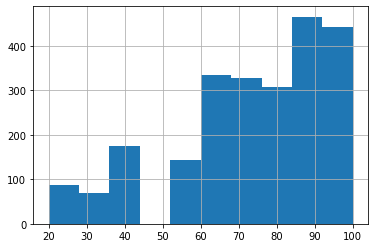

In [3]:
df["Rating"].hist()

Можно удалить stay, vacation, hotel, visit, experience и другие слова, не несущие никакой оценки(но в словах бывают ошибки => их нужно еще уметь отсекать с помощью какого-нибудь расстония Левенштейна). В аглийском можно так же почистить всякие предлоги по типу the, to, & etc(как я понимаю, можно отдельно не чистить - просто применить TF-IDF, у бесполезных слов будет низкий вес).Конечно же привести буквы к нижнему регистру, убрать nan'ы, заменив на "good", если рейтинг от 60 до 80, "awesome/excellent", если рейтинг "80"+, "bad" для ниже чем 40, "average" для рейтинга 40-60.

In [4]:
def titleOnRating(rating):
    if rating >= 80:
        return "awesome"
    elif rating >= 60:
        return "good"
    elif rating >= 40:
        return "average"
    else :
        return "bad"

In [5]:
nan_titles = df[df["Review_Title"].isna()].index
df.loc[nan_titles, "Review_Title"] = df.loc[nan_titles, "Rating"].apply(lambda x : titleOnRating(x))

In [6]:
df.loc[df["Review_Title"].sort_values()[:10].index]

,Id,Hotel_name,Review_Title,Review_Text,Rating
1414,1414,Le Royal M?ridien Chennai,"""Comfort at Reasonable Prize""!!!!!",I have stayed in Hotel Comfort Inn for couple ...,86.0
520,520,Samco,"""Nice food hotel""","Samco Hotel is lovely hotel in chennai,this ho...",65.0
1669,1669,Hotel Grand Residence Porur,0,.................................................,65.0
483,483,Deccan Plaza,0,. ...............................................,100.0
1775,1775,My Fortune Chennai,1,.................................................,65.0
590,590,Bell Hotel Chennai,1.11111111111111E+056,1.11111111111111E+249,86.0
2129,2129,Gemini Inn,2d/2n,Hotel location is excellent if you are looking...,57.0
2325,2325,Aloft Chennai Omr - It Expressway,3 star hotel with 5 star charges,I like to stay here because the location has m...,80.0
459,459,Grand Chennai by GRT Hotels,5 star experience,"Right from the word GO, great lives up to the ...",100.0
1090,1090,Oyo Rooms Omr Sholinganallur,5 star rooms at cheaper rates,I stayed in the hotel for a client meet and th...,71.0


Есть парочка строчек, в которых написан откровенный мусор, их нужно удалить, так же, как и колонку "Id"

In [7]:
df.drop(index=[1669, 483, 1775, 590], inplace=True)

In [8]:
df.drop("Id", axis=1, inplace=True)

In [9]:
df.head(10)

,Hotel_name,Review_Title,Review_Text,Rating
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
5,Everest,"Good atmosphere, food and drinks not available","I reached the hotel by car, felt good for co-o...",71.0
6,Metro Grand,Lovely hotel,The hotel is pretty clean with excellent beddi...,80.0
7,Oyo Rooms Anna Arch Arumbakkam,Not worth the money,No hot water.wifi limited to lobby. Average cl...,40.0
8,The Park Chennai,average,Hotel staff are not co-ordinating well for the...,40.0
9,FabHotel Priyadarshini Park Mount Road,Good hotel with poor services,Location and cleanliness is good. But as far a...,57.0


In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import wordnet, pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Никита\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Никита\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [12]:
def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return [lemmatizer.lemmatize(word, tag) for word, tag in pos_tagged]

In [1]:
import re, string

def preprocess_text(text): 
    stop_words = set(['those', 'on', 'own', '’ve', 'yourselves', 
                  'around', 'between', 'four', 'been', 'alone',
                  'off', 'am', 'then', 'other', 'can', 'regarding', 
                  'hereafter', 'front', 'too', 'used', 'wherein', '‘ll',
                  'doing', 'everything', 'up', 'onto', 'never', 'either', 
                  'how', 'before', 'anyway', 'since', 'through', 'amount', 
                  'now', 'he', 'was', 'have', 'into', 'because', 
                  'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see',
                  'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 
                  'whenever', 'seem', 'until', 'whereby', 'at', 'also', 
                  'some', 'last', 'than', 'get', 'already', 'our', 'once', 
                  'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 
                  'myself', 'out', 'next', 'whatever', 'although', 'though',
                  'which', 'would', 'therein', 'nor', 'somehow', 'whereupon',
                  'besides', 'whoever', 'ourselves', 'few', 'did', 'without',
                  'third', 'anything', 'twelve', 'against', 'while', 'twenty',
                  'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 
                  'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless',
                  'where', 'otherwise', 'still', 'within', 'its', 'for', 'together',
                  'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere',
                  'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere',
                  'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 
                  'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is',
                  'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both',
                  'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 
                  'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 
                  'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about',
                  'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 
                  'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty',
                  'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from',
                  'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across',
                  '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back',
                  'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 
                  'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after',
                  'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed',
                  'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers',
                  'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 
                  'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 
                  'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 
                  'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 
                  'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 
                  'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 
                  'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 
                  'make', 'were', 'whether', 'well', 'another', 'below', 'first', 
                  'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', 
                  '‘ve', 'to', 'be', 'a', 'the', 'hotel', 'room', 'apartament'])
    
    lemmas = my_lemmatizer(text.lower())
    keywords = ' '.join([lemma for lemma in lemmas if lemma not in stop_words])
    
    regex = re.compile('[%s]+' % re.escape(string.punctuation))
    text = regex.sub(' ', keywords)
    text = re.sub(r'\s+', ' ', text)
    return text

Применим лемматизацию к тайтлам и самим текстам отзывов:

In [14]:
df["Review"] = df[["Review_Title", "Review_Text"]].apply(lambda x : x[0] + " " + x[1], axis=1)

In [15]:
df.drop(columns=["Review_Title", "Review_Text"], inplace=True)

In [16]:
df["Review"] = df["Review"].apply(lambda x : preprocess_text(x))

In [17]:
vectoriser = TfidfVectorizer(ngram_range=(2,3))
tfidfgrams = vectoriser.fit_transform(df['Review'])
count_values = tfidfgrams.toarray().sum(axis=0)
vocab = vectoriser.vocabulary_
df_tfidfgram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'tfidf', 1:'bigram/trigram'})

df_tfidfgram[df_tfidfgram['tfidf'] >= 0.15]

,tfidf,bigram/trigram
0,16.285713,good good
1,16.167323,value money
2,14.909211,good stay
3,14.678904,service good
4,14.252258,good location
...,...,...
32906,0.150014,attractive staff
32907,0.150014,appearance pretty attractive
32908,0.150014,appearance pretty
32909,0.150014,allot good maintain


In [18]:
test = pd.read_csv("test.csv", encoding="ISO-8859-1")
test.head()

,Id,Hotel_name,Review_Title,Review_Text
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...
1,2352,Hotel Pandian,NaN,Not so great. But it is still acceptable. Bit...
2,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...
3,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...
4,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ..."


In [19]:
test['Review_Title'].fillna('', inplace=True)

In [20]:
test["Review"] = test[["Review_Title", "Review_Text"]].apply(lambda x : x[0] + " " + x[1], axis=1)

In [21]:
test["Review"] = test["Review"].apply(lambda x : preprocess_text(x))

In [22]:
vectoriser = TfidfVectorizer(ngram_range=(2,3))
tfidfgrams = vectoriser.fit_transform(test['Review'])
count_values = tfidfgrams.toarray().sum(axis=0)
vocab = vectoriser.vocabulary_
df_tfidfgram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'tfidf', 1:'bigram/trigram'})

df_tfidfgram

,tfidf,bigram/trigram
0,20.413493,value money
1,15.283537,good good
2,14.496945,good stay
3,14.383432,good service
4,13.874431,not good
...,...,...
56263,0.076005,gud gud nice
56264,0.076005,gud gud
56265,0.070267,visit again like
56266,0.070267,again like visit


In [24]:
vectoriser = TfidfVectorizer(ngram_range=(1,3))
tfidfgrams = vectoriser.fit_transform(pd.concat([df['Review'], test["Review"]], ignore_index=True))
count_values = tfidfgrams.toarray().sum(axis=0)
vocab = vectoriser.vocabulary_
result_tfidf = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'tfidf', 1:'bigram/trigram'})

result_tfidf

,tfidf,bigram/trigram
0,183.190641,good
1,110.454166,stay
2,88.418619,not
3,76.174109,service
4,73.065310,staff
...,...,...
100926,0.056057,fake pic fake
100927,0.056057,fake pic
100928,0.056057,fake everything life
100929,0.056057,fake everything


In [25]:
hotel_names = pd.concat([df["Hotel_name"], test['Hotel_name']], ignore_index=True)
hotels = pd.get_dummies(hotel_names)

In [27]:
full_df = pd.DataFrame(data=tfidfgrams.toarray(), columns=vectoriser.get_feature_names()).join(hotels)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
X_train = full_df.loc[:df.shape[0] - 1, :]
y_train = df["Rating"]
X_test = full_df.loc[df.shape[0] : , :]

In [29]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)

LinearSVC(random_state=42)

In [30]:
y_pred = model.predict(X_test)
y_pred

array([100.,  86.,  86., ...,  71.,  40.,  80.])

In [31]:
train_hotels = set(df["Hotel_name"].unique())

In [32]:
test_hotels = set(test["Hotel_name"].unique())

In [33]:
train_hotels.intersection(test_hotels)

{'Aadithya',
 'Abu sarovar portico ex Abu Palace',
 'Accord Metropolitan',
 'Akash Inn',
 'Akshay Inn',
 'Aloft Chennai Omr - It Expressway',
 'Ambica Empire',
 'Ammu Palace',
 'Annsun Boutique',
 'Apollo Serviced Apartments',
 'Apple Residency',
 'Aryaas',
 'Asiana Place',
 'Atchaya',
 'Avnb Towers',
 'Azeez Avenue',
 'BKR Grand',
 'Beach Park Resort',
 'Bell Hotel Chennai',
 'Benzz Park',
 'Beverly Hotel',
 'Bhimaas',
 'Bluten by Traditions Inn',
 'Brownstar Boutique Hotel',
 'Buhari Royale',
 'Chandra Park',
 'Chennai Palace',
 'Clarion Hotel President',
 'Cloud Nine Serviced Apartments',
 'Courtyard Chennai India',
 'Crescent Hospitality Chennai',
 'Crescent Park',
 'Crystal Residency',
 'Deccan Plaza',
 'Dee Cee Manor',
 'Dolphin Park',
 'E Hotel',
 'Ekaana Cottages',
 'Emarald',
 'Emerald Manor Chennai',
 'Esthell',
 'Everest',
 'FabHotel Blossoms T Nagar',
 'FabHotel Metro Manor Central Station',
 'FabHotel Priyadarshini Park Mount Road',
 'FabHotel Queensway T Nagar',
 'Feather

In [34]:
renamer = {"Hotel_name" : "Name", 0 : "Rating1"}
prediction_lookup = pd.concat([test["Hotel_name"], pd.Series(y_pred)], axis=1).rename(columns=renamer)
prediction_lookup.groupby("Name")["Rating1"].mean()

Name
Aadithya                              86.000000
Abu sarovar portico ex Abu Palace     79.500000
Accord Metropolitan                   85.539683
Akash Inn                             62.800000
Akshay Inn                           100.000000
                                        ...    
Victoria                              77.692308
Zama Lodge                            64.500000
Zone By The Park Orr Chennai          80.000000
ibis Chennai City Centre              90.000000
ibis Chennai Sipcot                   74.400000
Name: Rating1, Length: 245, dtype: float64

In [35]:
pd.concat([test["Hotel_name"], pd.Series(y_pred)], axis=1)

,Hotel_name,0
0,ITC Grand Chola,100.0
1,Hotel Pandian,86.0
2,Oyo Rooms Guindy Olympia Tech Park,86.0
3,OYO Apartments Saidapet,80.0
4,Ramada Chennai Egmore,80.0
...,...,...
2347,Lemon Tree Chennai,86.0
2348,Oyo Rooms T Nagar Off Pondy Bazaar,60.0
2349,VGP Golden Beach Resort,71.0
2350,The Park Chennai,40.0


In [36]:
df.groupby("Hotel_name")["Rating"].mean()

Hotel_name
Aadithya                             83.000000
Abu sarovar portico ex Abu Palace    79.666667
Accord Metropolitan                  82.475410
Akash Inn                            69.428571
Akshay Inn                           77.750000
                                       ...    
Yashwanth Residency                  60.000000
Zama Lodge                           64.500000
Zone By The Park Orr Chennai         86.666667
ibis Chennai City Centre             90.000000
ibis Chennai Sipcot                  63.800000
Name: Rating, Length: 243, dtype: float64

In [37]:
lookup = pd.concat([prediction_lookup.groupby("Name")["Rating1"].mean(), df.groupby("Hotel_name")["Rating"].mean()], axis=1)

In [38]:
result = lookup[lookup.notna().sum(axis=1) > 1]
result

,Rating1,Rating
Aadithya,86.000000,83.000000
Abu sarovar portico ex Abu Palace,79.500000,79.666667
Accord Metropolitan,85.539683,82.475410
Akash Inn,62.800000,69.428571
Akshay Inn,100.000000,77.750000
...,...,...
Victoria,77.692308,82.000000
Zama Lodge,64.500000,64.500000
Zone By The Park Orr Chennai,80.000000,86.666667
ibis Chennai City Centre,90.000000,90.000000


In [76]:
from sklearn.metrics import mean_squared_error
print("On the crossing hotels we have RMSE score = {}".format(mean_squared_error(result["Rating1"], result["Rating"], squared=False)))

On the crossing hotels we have RMSE score = 9.368145940957136


In [77]:
# в пересчете на количество измерений: 
mean_squared_error(result["Rating1"], result["Rating"], squared=False) / 232

0.040379939400677314

Попробуем так же добавить для каждого отзыва признак "процент хороших слов" и "процент плохих слов" из данных табличек

In [41]:
concat_review = pd.concat([df['Review'], test["Review"]], ignore_index=True)

In [52]:
positive_words = set(pd.read_fwf("positive-words.txt")['a+'].values)
negative_words = set(pd.read_fwf("negative-words.txt")["2-faced"].values)

In [82]:
def find_percent(flag, text):
    text = text.split()
    lenght = len(text)
    counter = dict()
    words = 0
    for word in text:
        if counter.get(word) is None:
            counter[word] = 0
        counter[word] += 1
    
    if flag == 1:
        for word, count in counter.items():
            if word in positive_words:
                words += count
        return words / lenght
    else :
        for word, count in counter.items():
            if word in negative_words:
                words += count
        return -words / lenght

In [83]:
full_df["positive"] = concat_review.apply(lambda x : find_percent(1, x))
full_df["negative"] = concat_review.apply(lambda x : find_percent(-1, x))

In [84]:
X_train = full_df.loc[:df.shape[0] - 1, :]
y_train = df["Rating"]
X_test = full_df.loc[df.shape[0] : , :]

In [85]:
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [89]:
renamer = {"Hotel_name" : "Name", 0 : "Rating2"}
prediction_lookup = pd.concat([test["Hotel_name"], pd.Series(y_pred1)], axis=1).rename(columns=renamer)
lookup1 = pd.concat([prediction_lookup.groupby("Name")["Rating2"].mean(), df.groupby("Hotel_name")["Rating"].mean()], axis=1)
result1 = lookup1[lookup1.notna().sum(axis=1) > 1]
print("On the crossing hotels we have RMSE score = {}".format(mean_squared_error(result1["Rating2"], result1["Rating"], squared=False)))

On the crossing hotels we have RMSE score = 9.645564124531486


Почему-то от этих двух признаков не стало лучше((но стало чуточку хуже на пересечении отелей, может быть для новых отелей этот признак всё таки полезен)

добавить еще 1 признак - 
emotional coloring, который будет смотреть в таблицу расширенную, смотреть на значения positive и negative и вычитать второе из первого

In [112]:
words = pd.read_csv("SentiWordNet.txt", sep='\t')
#if 'good'.isin(words["Word"]):
#    print(word)

In [150]:
def emotional_coloring(text):
    text = set(text.split())
    lenght = len(text)
    color = 0
    wordsss =  set(words['Word'].values)
    for word in text:
        if word in wordsss:
            index = words[words['Word'] == word].index
            pos = words.loc[index, 'Positive'].iloc[0]
            neg = words.loc[index, 'Negative'].iloc[0]
            color += (pos - neg) * index.shape[0] 
    return color

In [156]:
full_df['emotional_coloring'] = concat_review.apply(lambda x : emotional_coloring(x))

In [157]:
X_train = full_df.loc[:df.shape[0] - 1, :]
y_train = df["Rating"]
X_test = full_df.loc[df.shape[0] : , :]

In [163]:
model = LinearSVC(random_state=42, max_iter=100000)
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

In [164]:
renamer = {"Hotel_name" : "Name", 0 : "Rating3"}
prediction_lookup = pd.concat([test["Hotel_name"], pd.Series(y_pred2)], axis=1).rename(columns=renamer)
lookup2 = pd.concat([prediction_lookup.groupby("Name")["Rating3"].mean(), df.groupby("Hotel_name")["Rating"].mean()], axis=1)
result2 = lookup2[lookup2.notna().sum(axis=1) > 1]
print("On the crossing hotels we have RMSE score = {}".format(mean_squared_error(result2["Rating3"], result2["Rating"], squared=False)))

On the crossing hotels we have RMSE score = 9.470301137343732


In [168]:
pd.Series(y_pred2).to_csv("D:/python/Tinkoff/nlp/nlp_result.csv")

0       100.0
1        80.0
2        86.0
3        80.0
4        80.0
        ...  
2347     60.0
2348     60.0
2349     71.0
2350     40.0
2351     80.0
Length: 2352, dtype: float64